# Notícias G1 - 8. Classificação com Redes Neurais Exemplo Básico

Será feita a classificação das notícias de categoria desconhecida com base no modelo treinado a partir de um modelo de rede neural e da massa de dados com categoria conhecida. 

Serão utilizadas três camadas contendo 5, 5 e 7 neurônios respectivamente. Nesse exemplo todos os parâmetros são um mero chute. O objetivo é demonstrar a utilização básica sem se preocupar com o desempenho da rede ou buscar pela melhor parametrização.

## Imports:

Importes de bibliotecas usadas com frequência no código.

In [24]:
import pandas as pd
import numpy as np

## Recuperando Dados Gravados:

Recuperando dados gravados após cálculo de TF-IDF e criação de matrizes esparças.

In [25]:
df_tfidf_classificar = pd.read_csv("noticias_g1_tfidf_massa_classificar.csv")
df_tfidf_treino = pd.read_csv("noticias_g1_tfidf_massa_treino.csv")
df_tfidf_teste = pd.read_csv("noticias_g1_tfidf_massa_teste.csv")
df_cat_treino = pd.read_csv("noticias_g1_categorias_treino.csv")
df_cat_teste = pd.read_csv("noticias_g1_categorias_teste.csv")

print(df_tfidf_classificar.shape, df_tfidf_treino.shape, 
      df_cat_treino.shape, df_tfidf_teste.shape, df_cat_teste.shape)

(2111, 2442) (1206, 2442) (1206, 1) (517, 2442) (517, 1)


## One Hot Encoder:

Como trata-se de um problema multiclasse vamos precisar utilizar a técnica one-hot-encoding. Nessa técnica é criada uma matriz onde cada classe torna-se uma coluna e, para cada registro, apenas a coluna da classe correta é sinalizada com valor 1, as demais colunas permanecem com zeros. 

O objetivo disso e tornar variáveis categóricas processáveis pela rede neural sem, contudo, utilizar ordem de grandeza pela atribuição de números inteiros - técnica conhecida como label enconding.

In [26]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(df_cat_treino.to_numpy())
ohe_cat_treino = one_hot_encoder.transform(df_cat_treino.to_numpy())

df = pd.DataFrame(ohe_cat_treino)
df.columns = one_hot_encoder.categories_
df.to_csv('noticias_g1_one_hot_encoder.csv', index=False)

df

,diversos,economia,educacao,politica,pop-arte,saude
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1201,0.0,1.0,0.0,0.0,0.0,0.0
1202,0.0,0.0,0.0,1.0,0.0,0.0
1203,0.0,1.0,0.0,0.0,0.0,0.0
1204,0.0,1.0,0.0,0.0,0.0,0.0


## Criando Matrizes Esparsas:

Transformando os DataFrames em matrizes esparças para utilizar na classificação com rede neural.

In [27]:
from scipy.sparse import coo_matrix, vstack

sm_classificar = coo_matrix(df_tfidf_classificar)
sm_treino = coo_matrix(df_tfidf_treino)
sm_teste = coo_matrix(df_tfidf_teste)
sm_cat_treino = np.array(df_cat_treino)
sm_cat_teste = np.array(df_cat_teste)

print(sm_classificar.shape, sm_treino.shape, sm_cat_treino.shape,
      sm_teste.shape, sm_cat_teste.shape)

(2111, 2442) (1206, 2442) (1206, 1) (517, 2442) (517, 1)


## Tratando Desbalanceamento das Classes:

Como as classes estão muito desbalanceadas faremos o tratamento desse problema por meio do ajuste dos pesos para cada categoria. Isso será feito usando o sklearn.

In [28]:
from sklearn.utils import class_weight

y_integers = np.argmax(ohe_cat_treino, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 25.125,
 1: 0.43412526997840173,
 2: 7.178571428571429,
 3: 0.5726495726495726,
 4: 0.8854625550660793,
 5: 1.558139534883721}

## Rede Neural - Treinamento:

Realiza o treinamento para a classificação com o código mais básico possível.
Os parâmetros foram definidos aleatoriamente.

In [29]:
# Definindo Variáveis do problema:
X_train = sm_treino
X_test = sm_teste
y_train = ohe_cat_treino
y_test = sm_cat_teste

In [45]:
#!pip install keras
#!pip install tensorflow

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import activations
import tensorflow

# Setting Random Seeds:
random_seed = 33
np.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

# Formating Net
net = Sequential()
net.add(Dense(units=10, kernel_initializer='uniform', activation=activations.relu, input_dim=X_train.shape[1]))
net.add(Dense(units=10, kernel_initializer='uniform', activation=activations.relu))
net.add(Dense(units=6 , kernel_initializer='uniform', activation=activations.sigmoid))

# Cooking
net.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
net.fit(X_train, y_train, batch_size=10, epochs=100, class_weight=d_class_weights)


Epoch 1/100


/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 2s 5ms/step - loss: 0.7009 - accuracy: 0.0746
Epoch 2/100
121/121 [==============================] - 1s 5ms/step - loss: 0.4383 - accuracy: 0.1401
Epoch 3/100
121/121 [==============================] - 1s 4ms/step - loss: 0.4712 - accuracy: 0.1051
Epoch 4/100
121/121 [==============================] - 1s 5ms/step - loss: 0.4538 - accuracy: 0.1234
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.4786 - accuracy: 0.1332
Epoch 6/100
121/121 [==============================] - 0s 4ms/step - loss: 0.3982 - accuracy: 0.2567
Epoch 7/100
121/121 [==============================] - 0s 3ms/step - loss: 0.4295 - accuracy: 0.1275
Epoch 8/100
121/121 [==============================] - 0s 4ms/step - loss: 0.4878 - accuracy: 0.1099
Epoch 9/100
121/121 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.0934
Epoch 10/100
121/121 [==============================] - 0s 3ms/step - loss: 0.4089 - accuracy: 0.2483
E

121/121 [==============================] - 0s 3ms/step - loss: 6.0979e-04 - accuracy: 1.0000
Epoch 82/100
121/121 [==============================] - 0s 3ms/step - loss: 3.9103e-04 - accuracy: 1.0000
Epoch 83/100
121/121 [==============================] - 0s 3ms/step - loss: 3.0613e-04 - accuracy: 1.0000
Epoch 84/100
121/121 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 85/100
121/121 [==============================] - 0s 3ms/step - loss: 4.1798e-04 - accuracy: 1.0000
Epoch 86/100
121/121 [==============================] - 0s 3ms/step - loss: 3.3056e-04 - accuracy: 1.0000
Epoch 87/100
121/121 [==============================] - 0s 3ms/step - loss: 3.3250e-04 - accuracy: 1.0000
Epoch 88/100
121/121 [==============================] - 0s 3ms/step - loss: 3.6344e-04 - accuracy: 1.0000
Epoch 89/100
121/121 [==============================] - 0s 3ms/step - loss: 4.3034e-04 - accuracy: 1.0000
Epoch 90/100
121/121 [==============================] - 0s 3ms/

## Perda ao Longo das Épocas:

Vamos observar a taxa de erro ao longo do processamento conforme as épocas do treinamento.

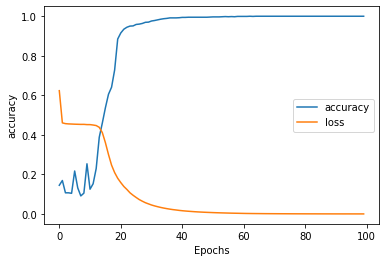

In [55]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['loss'])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'loss'])
  plt.show()
  
plot_graphs(net.history, "accuracy")

## Classificação com a Massa de Teste:

Será feita a classificação da massa de dados separada para teste.

In [62]:
prediction_massa_teste = net.predict(X_test)
prediction_massa_teste

array([[1.66646728e-26, 4.09032509e-06, 4.95183702e-29, 9.99997675e-01,
        1.91777167e-06, 2.00493240e-22],
       [1.24991595e-14, 9.99869108e-01, 5.17290237e-35, 2.48372451e-08,
        2.91018461e-26, 1.72644854e-04],
       [1.32763687e-13, 9.99802589e-01, 3.59832151e-31, 1.44227295e-06,
        1.51129657e-22, 7.34309506e-05],
       ...,
       [3.90747466e-13, 9.99829292e-01, 3.07269263e-31, 6.95364179e-07,
        1.19775250e-22, 4.87684156e-05],
       [1.63405714e-30, 2.55949772e-07, 7.54447262e-33, 9.99999583e-01,
        2.39928312e-07, 7.97758665e-25],
       [8.47914934e-25, 0.00000000e+00, 2.08526501e-07, 2.45783849e-06,
        1.00000000e+00, 0.00000000e+00]], dtype=float32)

## Elucidando a Saída - Massa Teste:

O resultado da predição é um array com N valores para cada registro classificado. Esses N valores correspondem as N categorias/classes que foram dadas ao modelo no treinamento. 

A seguir vamos separar para cada linha qual é o maior valor dentre os N fornecidos e, pela posição no array, identificar qual a categoria mais bem cotada.

In [63]:
one_hot_encoder.categories_[0]

array(['diversos', 'economia', 'educacao', 'politica', 'pop-arte',
       'saude'], dtype=object)

In [72]:
classificacao_massa_teste = []
for notas in prediction_massa_teste:
    for x in range(len(notas)):
        if notas[x] == notas.max():
            if notas[x] > 0.000005:
                classificacao_massa_teste.append(one_hot_encoder.categories_[0][x])
            else:
                classificacao_massa_teste.append('diversos')
np.unique(classificacao_massa_teste)

array(['diversos', 'economia', 'educacao', 'politica', 'pop-arte',
       'saude'], dtype='<U8')

## Classificação com a Massa Desconhecida:

Será feita a classificação com a massa de dados cuja categoria é desconhecida.

In [73]:
prediction_massa_desconhecida = net.predict(sm_classificar)
prediction_massa_desconhecida

array([[9.8949766e-01, 4.7606472e-06, 3.6520660e-03, 1.1598137e-09,
        6.5782068e-08, 2.7352870e-03],
       [9.3257002e-09, 1.7085572e-13, 5.5673115e-13, 1.8430674e-11,
        9.2007200e-12, 2.9247495e-13],
       [7.3548962e-09, 9.6402228e-02, 1.5102281e-25, 5.7929985e-13,
        5.3254614e-25, 8.6312056e-02],
       ...,
       [8.3834764e-15, 8.0250963e-21, 1.2635781e-08, 3.6598871e-05,
        7.9945052e-01, 1.2185314e-24],
       [3.4497678e-03, 4.8444510e-10, 2.3222113e-11, 6.3315844e-15,
        4.9590719e-16, 6.5427075e-06],
       [3.8260562e-12, 7.7014697e-01, 3.5648781e-22, 2.5372803e-03,
        9.7824370e-14, 4.6306488e-07]], dtype=float32)

## Elucidando a Saída - Massa Desconhecida:

Vamos converter a saída, que é uma matriz numérica, para um resultado legível como fizemos com a predição sobre a massa de teste.

In [74]:
classificacao_massa_desconhecida = []
for notas in prediction_massa_desconhecida:
    for x in range(len(notas)):
        if notas[x] == notas.max():
            if notas[x] > 0.000005:
                classificacao_massa_desconhecida.append(one_hot_encoder.categories_[0][x])
            else:
                classificacao_massa_desconhecida.append('diversos')

np.unique(classificacao_massa_desconhecida)

array(['diversos', 'economia', 'educacao', 'politica', 'pop-arte',
       'saude'], dtype='<U8')

## Análise dos Resultados: Distribuição por Categoria:

Elabora gráficos para comparar a distribuição dos dados na massa de treino, de teste, e de classificação (cuja categoria é desconhecida).

In [75]:
# Calculando a distribuição:

from collections import Counter, OrderedDict

counter = sorted(Counter(df_cat_treino['cat']).items(), key=lambda i: i[0])
dist_treino = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(df_cat_teste['cat']).items(), key=lambda i: i[0])
dist_teste = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(classificacao_massa_teste).items(), key=lambda i: i[0])
dist_teste_ = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(classificacao_massa_desconhecida).items(), key=lambda i: i[0])
dist_classificacao = pd.DataFrame(counter, columns=['cat', 'qtd'])

print(dist_teste.shape, dist_teste_.shape, dist_classificacao.shape)

(6, 2) (6, 2) (6, 2)


/Users/edprata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


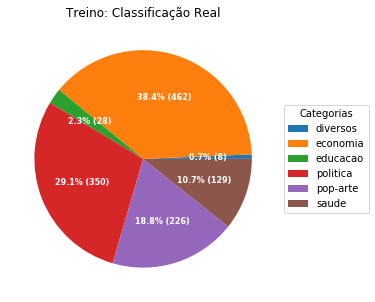

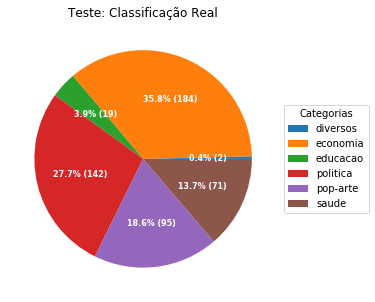

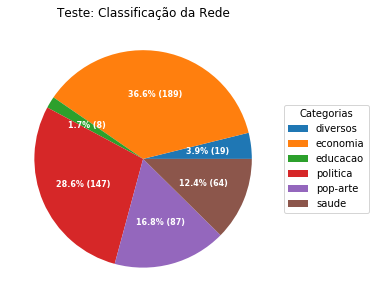

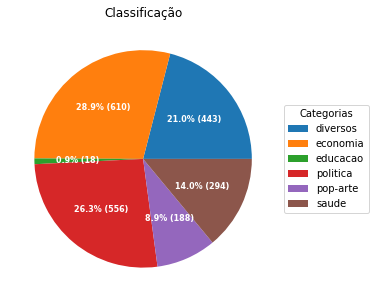

In [76]:
import matplotlib.pyplot as plt

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

def pie(title, legend, data, label):
  fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect="equal"))
  wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
  ax.legend(wedges, label, title=legend, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
  plt.setp(autotexts, size=8, weight="bold")
  ax.set_title(title)
  plt.show()

pie("Treino: Classificação Real", "Categorias", dist_treino[['qtd']], dist_teste['cat'])
pie("Teste: Classificação Real", "Categorias", dist_teste[['qtd']], dist_teste['cat'])
pie("Teste: Classificação da Rede", "Categorias", dist_teste_[['qtd']], dist_teste_['cat'])
pie("Classificação", "Categorias", dist_classificacao[['qtd']], dist_classificacao['cat'])

De cara percebemos que os gráficos com a massa de treino e teste ficaram muito parecidos, dando indícios de uma boa distribuição dessa massa.

A classificação de teste também ficou bastante parecida com os gráficos anteriores, com perda sigificativa apenas da categoria "educação" que está bem desbalanceada. Talvez o ajuste dos pesos não tenha sido suficiente.

Na classificação final vemos sobressair a categoria "desconhecida" o que sabemos que é verdade, pois há muitas notícias nessa massa cuja categoria não existe na massa de treino.

### Gráfico de Barras Comparando Real com Predito na Massa de Teste

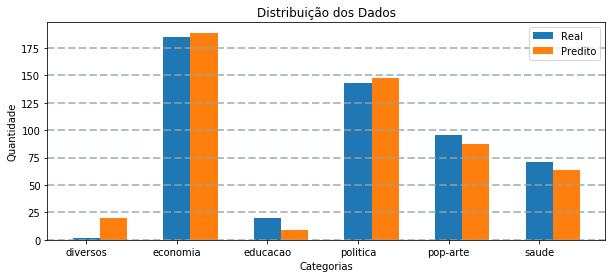

In [77]:
plt.figure(figsize=[10,4])
plt.title("Distribuição dos Dados")
plt.xlabel('Categorias')
plt.ylabel('Quantidade')
plt.xticks(range(6), dist_teste['cat'])
plt.bar(np.arange(6), dist_teste['qtd'], width=0.3, label='Real')
plt.bar(np.arange(6) + 0.3, dist_teste_['qtd'], width=0.3, label='Predito')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.legend()
plt.show();

No gráfico de barras fica ainda mais evidente as diferenças para educação e desconhecida.

### Métricas

In [78]:
y_true = df_cat_teste['cat']
y_pred = classificacao_massa_teste

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Acurácia: ', round(accuracy_score(y_true, y_pred), 3))
print('Recall  : ', round(np.mean(recall_score(y_true, y_pred, average=None, labels=np.unique(y_pred))), 3))
print('Precisão: ', round(np.mean(precision_score(y_true, y_pred, average=None)), 3))
print('F1      : ', round(np.mean(f1_score(y_true, y_pred, average=None, labels=np.unique(y_pred))), 3))

Acurácia:  0.884
Recall  :  0.754
Precisão:  0.793
F1      :  0.725


### Matrix de Confusão

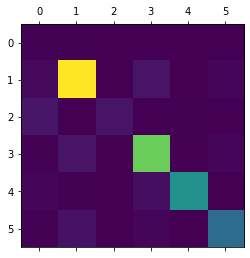

In [80]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
df_matrix = pd.DataFrame(matrix, index=np.unique(y_true), columns=np.unique(y_true))
plt.matshow(df_matrix);

### Heat Map

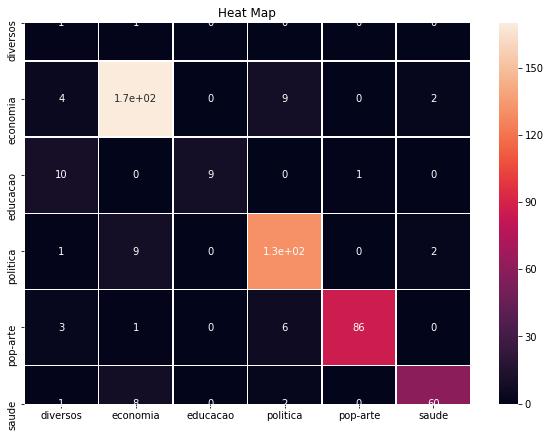

In [81]:
import seaborn as sn
plt.figure(figsize=(10,7))
plt.title("Heat Map")
sn.heatmap(df_matrix, annot=True, linewidths=.5, annot_kws={"size":10})